# HW 10 CLUSTERING BUSINESS

**cluster time trends in NYC businesses: **

**Census Business data:**
- Download census data for businesses by ZIP code. the data is here

http://www.census.gov/econ/cbp/download/
- and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [ ]:
$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

$ for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


**NYC zip codes shape file is here**


http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


In [33]:
#Load packages
import requests, zipfile
#from io import BytesIO
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering



%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TASKS:
    
**Get and prep your data.**

In [120]:
census = {}

doc_years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
                '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']


for i in doc_years:
    #unzip file, save to temporary dataframe with standardized column names
    #add this temp dataframe to dict that will hold all
    fname = 'zbp{0}totals.zip'.format(i)
    zf = zipfile.ZipFile(fname)
    temp = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
  
    temp.columns = [x.lower() for x in temp.columns] 
    temp['zip'] = temp['zip'].astype(str) #For subsequent merge
    census[i] = temp
    
#census.keys()    

In [43]:
#census[1994].describe().T

#get only the zip codes in NYC
fname = 'nyc-zip-code-tabulation-areas-polygons.geojson'
zc = gpd.read_file(fname)

zc.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.87440,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.91390,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6269333.41234,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.05770,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.59430,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


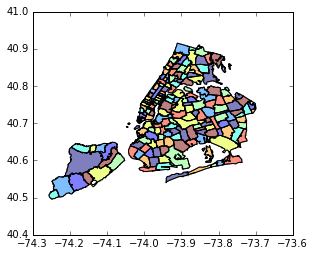

In [162]:
zc.plot()

In [121]:
#grab zip codes in NYC from shapefile
data = pd.DataFrame(columns=['zip'])
data['zip'] = zc['postalCode']

In [122]:
#Merge all years on 'establishments'
for year, temp in census.items():
    data = data.merge(temp[['zip', 'est']], on='zip', how='left').rename(columns={'est': 'est_{}'.format(year)})


In [123]:
#there are duplicate zips in the geofile, drop them

data.index = data['zip']
data = data.drop('zip',1).drop_duplicates()

In [124]:
#some zips don't have any data
data_final = data.dropna(axis=0, how='any')

In [126]:
data_final.shape

(230, 20)

In [127]:
data_final.head()

,est_98,est_99,est_00,est_96,est_03,est_02,est_94,est_95,est_04,est_01,est_12,est_09,est_08,est_07,est_10,est_97,est_05,est_13,est_11,est_06
zip,,,,,,,,,,,,,,,,,,,,
11372,1351,1376,1409,1292,1521,1463,1229,1236,1554,1408,1724,1572,1538,1545,1629,1309,1539,1759,1647,1527
11004,194,186,189,176,228,214,194,188,226,204,241,233,227,238,229,192,225,241,222,226
11040,1344,1350,1350,1335,1403,1398,1422,1414,1406,1341,1510,1475,1503,1488,1494,1344,1441,1539,1488,1454
11426,203,217,213,209,211,207,326,219,221,217,266,237,226,228,248,198,226,258,256,226
11365,509,519,553,483,582,574,492,476,599,574,679,628,616,617,643,522,604,714,677,608


In [129]:
#reorder the columns 
cols = ['est_' + s for s in doc_years]
data_final = data_final[cols]

In [130]:
data_final.columns

Index(['est_94', 'est_95', 'est_96', 'est_97', 'est_98', 'est_99', 'est_00',
       'est_01', 'est_02', 'est_03', 'est_04', 'est_05', 'est_06', 'est_07',
       'est_08', 'est_09', 'est_10', 'est_11', 'est_12', 'est_13'],
      dtype='object')

**Cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)**
 

In [131]:
print(data_final.shape)

# standardize the data down each column

X = StandardScaler().fit_transform(data_final)


(230, 20)


**Plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).**

For n_clusters = 2 The average silhouette_score is : 0.831958913932
For n_clusters = 3 The average silhouette_score is : 0.691165494902
For n_clusters = 4 The average silhouette_score is : 0.564928290424
For n_clusters = 5 The average silhouette_score is : 0.568193453948
For n_clusters = 6 The average silhouette_score is : 0.56544747001
For n_clusters = 7 The average silhouette_score is : 0.540624190735
For n_clusters = 8 The average silhouette_score is : 0.541089369213


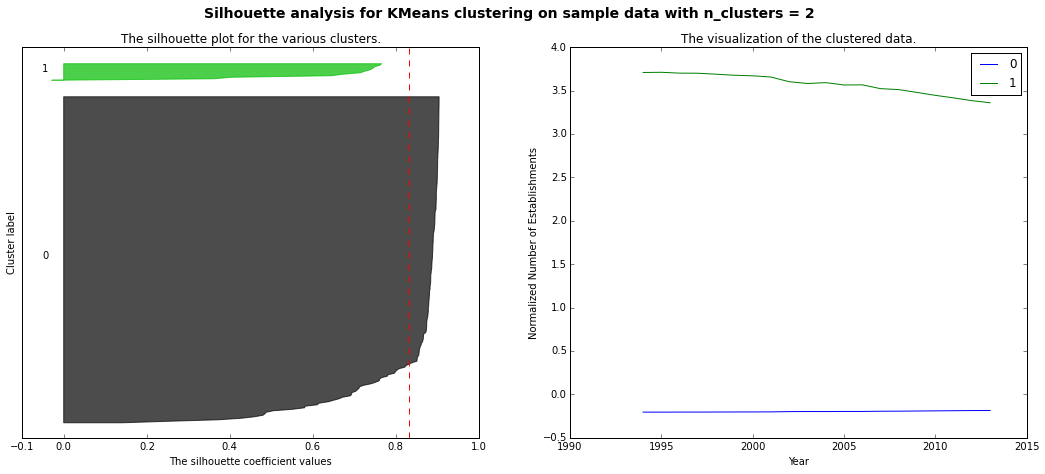

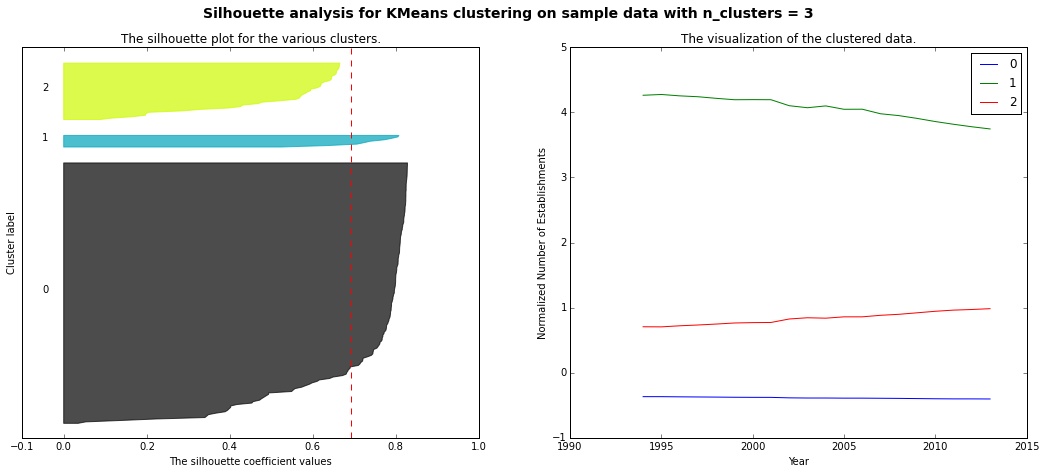

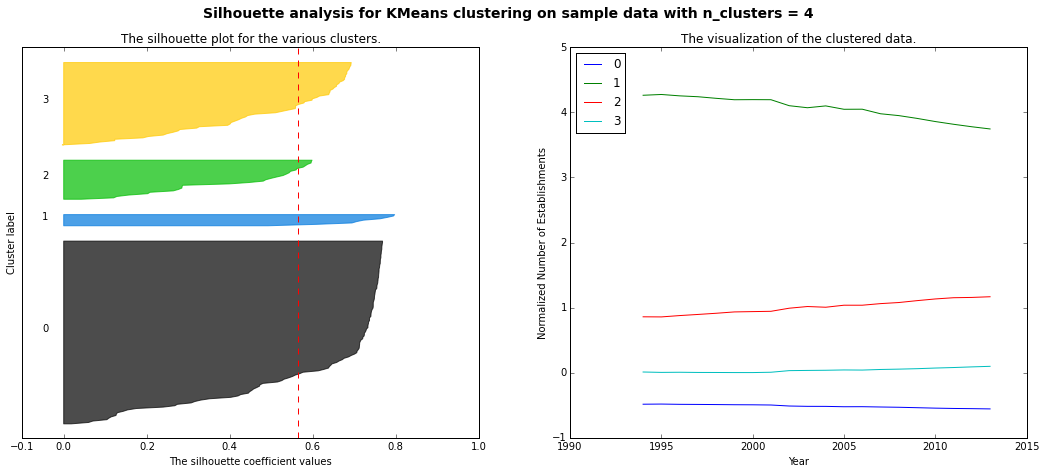

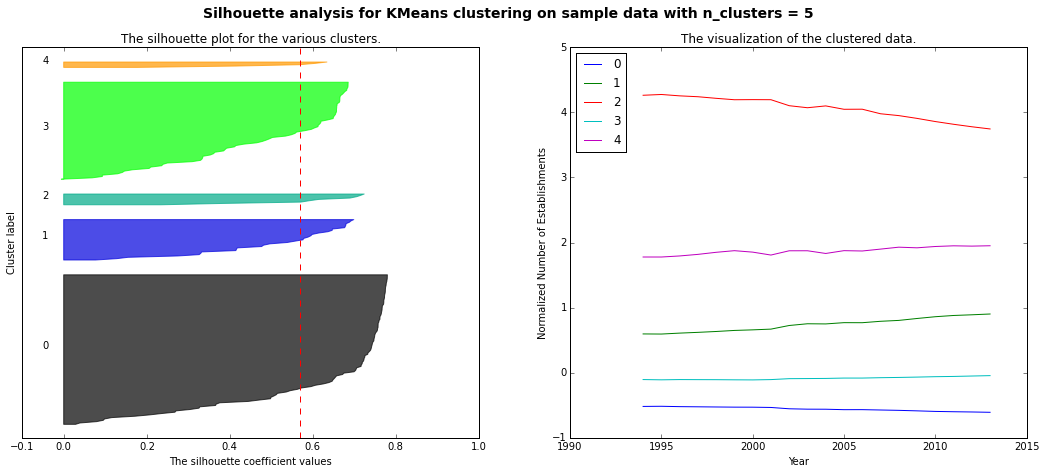

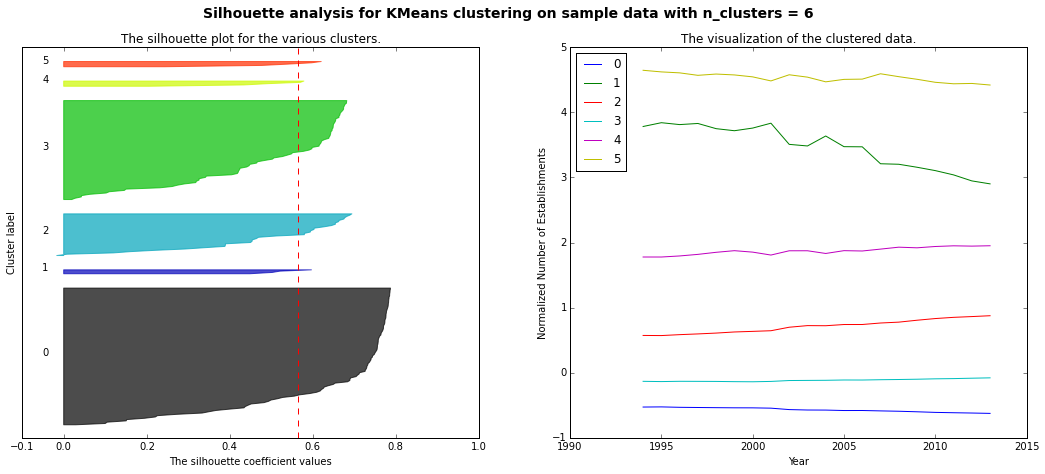

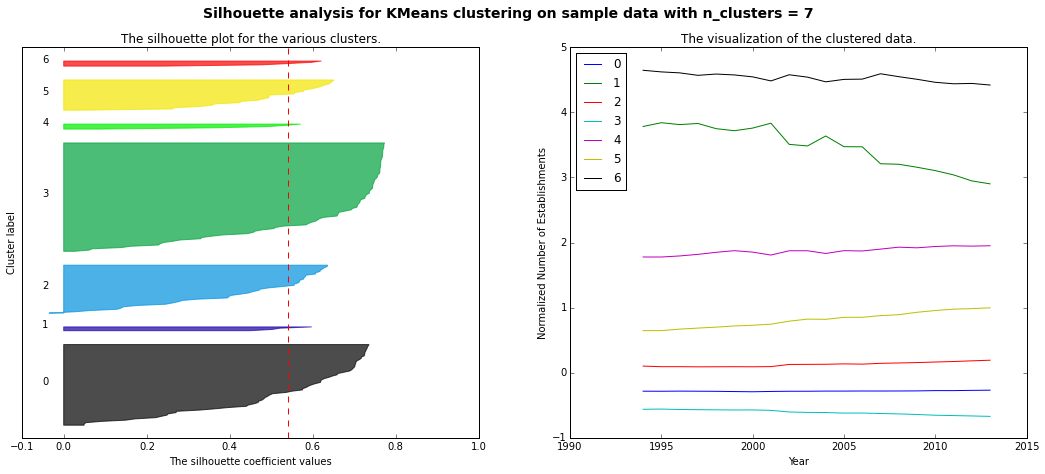

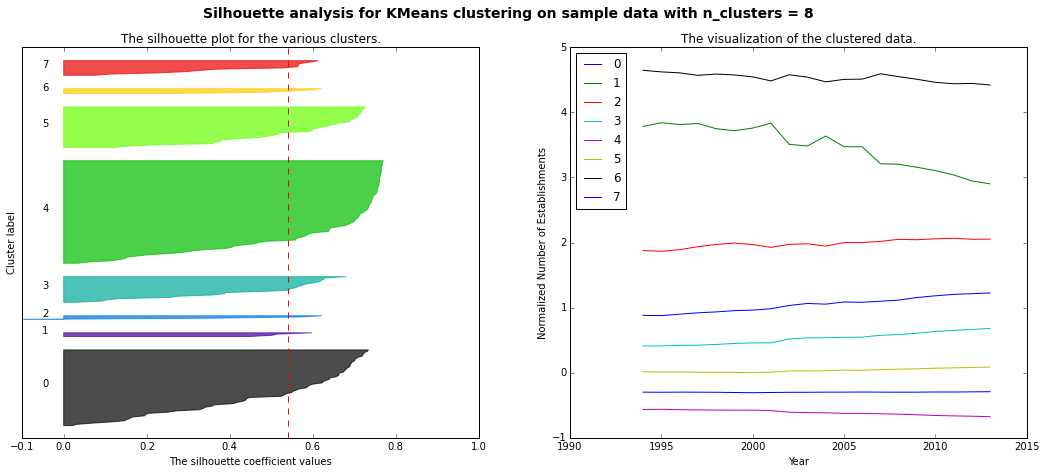

In [142]:
#adapted from SKLearn documentation


data_centroids = {}
data_centers = {}

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    #SAVE CENTROIDS FOR MAPPING LATER:
    data_centroids[str(n_clusters)] = cluster_labels
    a = clusterer.fit(X)
    data_centers[str(n_clusters)] = a.cluster_centers_
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    for i in range(n_clusters):
        ax2.plot(range(1994,2014), data_centers[str(n_clusters)][i], label=i)
        ax2.legend(loc=0)
      
    #ax2.plot(range(1994,2013), scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Normalized Number of Establishments")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {0}".format(n_clusters)),
                 fontsize=14, fontweight='bold')


**I could use n_clusters = 3, but visually I want more than three clusters, so the highest silhouette score comes at n_clusters = 5**

**Use another clustering algorithm (of your choice)**

**AGGLOMERATIVE CLUSTERING (bottom up heirarchal)**

In [143]:
#fit a Aff Cluster tree
agg = AgglomerativeClustering(n_clusters=5, compute_full_tree=True).fit(X)

#export zip code cluster labels to dataframe
data_final['agg_clusters']=agg.labels_

In [144]:
#export kmeans zip code clusters to dataframe
data_final['kmeans_clusters'] = data_centroids['5']

**Compare the results of the 2 algorithms**

In [149]:
mapping = data_final[['agg_clusters', 'kmeans_clusters']].reset_index()
mapping.head()

,zip,agg_clusters,kmeans_clusters
0,11372,1,1
1,11004,3,0
2,11040,1,1
3,11426,3,0
4,11365,2,3


In [150]:
mapping = gpd.GeoDataFrame(mapping.merge(zc[['postalCode', 'geometry']], left_on='zip', right_on='postalCode'))

Overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

/usr/local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


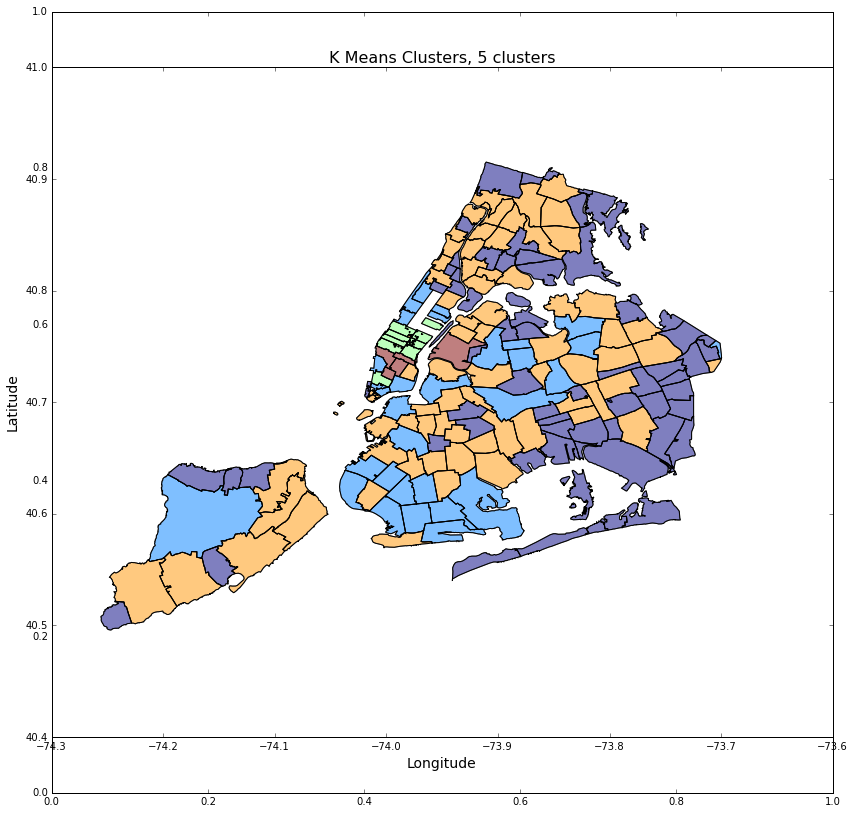

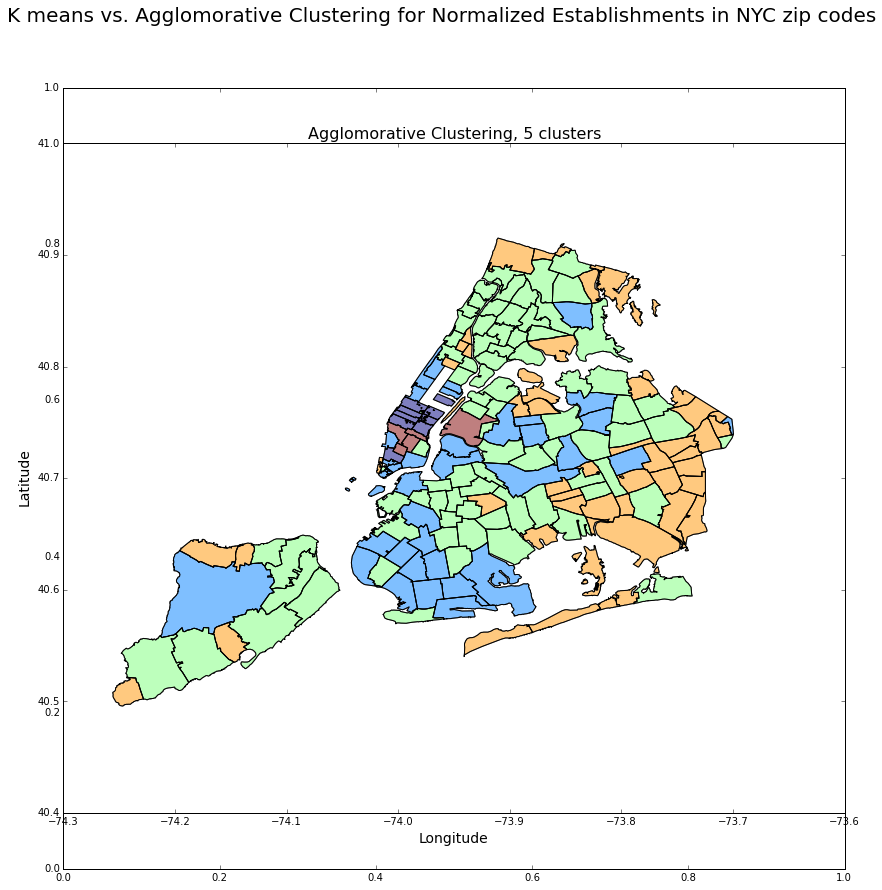

In [165]:
f, ax = plt.subplots(1, figsize=(14,14))
mapping.plot(column='kmeans_clusters')
plt.title('K Means Clusters, 5 clusters', fontsize = 16)
plt.legend()
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)
f2, ax2 = plt.subplots(1, figsize=(14,14))
mapping.plot(column='agg_clusters')
plt.legend()
plt.title('Agglomorative Clustering, 5 clusters',fontsize = 16)
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)

plt.suptitle('K means vs. Agglomorative Clustering for Normalized Establishments in NYC zip codes', fontsize=20)

**Attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. **

The clustering between Kmeans and Agglomerative do not differ substantially.  They have large orverlaps in the zip codes that comprise each cluster. In terms of interpreting the actual clusters, the middle three for K means (2,3,4) have all seen a similiar rate of growth of businesses over the past 20 years, though their starting baselines differ, hence why why were all grouped together.  Midtown Manhattan (green on K- mean cluster 1, Purple on Agg.) has seen relatively flat growth over the past two decades, largely due to the stagnant grown in the last decade.  Next steps would be to compare the clustering to a few different techniques such as affinity proprogation and CART trees to see if there is an difference in the groupings of zip codes!



**SOME NOTES BELOW**

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

For time series you don't whiten, you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

